Energy forecast with ML

In [33]:
import kaggle
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


In [34]:
# Some functions to help with time series analysis

def extract_time_data(df_o):
    """This function extracts time-related features from a DataFrame with a DateTime index."""
    df= df_o.copy()
    df['Year'] =  df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Hour'] = df.index.hour
    return df

def analyse_ADF_sstats(result_ADF):
    """This function analyses the results of the Augmented Dickey-Fuller test. And compares the ADF statistic with critical values and p-value."""
    adf_stat = result_ADF[0]
    p_val = result_ADF[1]
    crit_val_1 = result_ADF[4]['1%']
    crit_val_5 = result_ADF[4]['5%']
    crit_val_10 = result_ADF[4]['10%']

    print(f'ADF Statistic: {adf_stat}')
    print(f'p-value: {p_val}')
    print(f'Critical Value (1%): {crit_val_1}')
    print(f'Critical Value (5%): {crit_val_5}')
    print(f'Critical Value (10%): {crit_val_10}')
    
    if adf_stat < crit_val_1:
        print("Reject the null hypothesis: The time series is stationary at 1% significance level.")
    elif adf_stat < crit_val_5:
        print("Reject the null hypothesis: The time series is stationary at 5% significance level.")
    elif adf_stat < crit_val_10:
        print("Reject the null hypothesis: The time series is stationary at 10% significance level.")
    else:
        print("Fail to reject the null hypothesis: The time series is non-stationary.")

In [35]:
# I am using the Kaggle API to access datasets related to energy.
kaggle.api.authenticate()
!kaggle datasets list -s 'energy'

ref                                                             title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
robikscube/hourly-energy-consumption                            Hourly Energy Consumption                           11979477  2018-08-30 14:17:03.317000          92464       1060  1.0              
pralabhpoudel/world-energy-consumption                          World Energy Consumption                             2363711  2023-11-26 00:57:10.697000          22431        202  1.0              
unitednations/international-energy-statistics                   International Energy Statistics                      7709566  2017-11-16 00:06:06.683000          13236        289  0.7058824        
loveall/ap

In [36]:
#Download the dataset and store it in the data folder 
#kaggle.api.dataset_download_files('robikscube/hourly-energy-consumption', path='./data', unzip=True) 

In [37]:
#Openeing the dataset and see what data it contains
henergy_df = pd.read_csv("..\data\AEP_hourly.csv")
henergy_df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


## EDA and data preprocessing


One important step is to explore the data and see what is to be faced, if there are any missing values, outliers, that can affect the model performance and expplore the nature of the data to make some preprocessing and feature engineering.

In [38]:
# check if the data has missing values
henergy_df.notna().value_counts()

Datetime  AEP_MW
True      True      121273
dtype: int64

The data has no missing values. I will skip the preprocessing step of handling missing values.

In [39]:
# There are some dates, however the data is imported as a string, so we need to convert it to datetime format. 
henergy_df.Datetime = pd.to_datetime(henergy_df.Datetime) # convert to datetime so that we can use it as an index
henergy_df.info

<bound method DataFrame.info of                   Datetime   AEP_MW
0      2004-12-31 01:00:00  13478.0
1      2004-12-31 02:00:00  12865.0
2      2004-12-31 03:00:00  12577.0
3      2004-12-31 04:00:00  12517.0
4      2004-12-31 05:00:00  12670.0
...                    ...      ...
121268 2018-01-01 20:00:00  21089.0
121269 2018-01-01 21:00:00  20999.0
121270 2018-01-01 22:00:00  20820.0
121271 2018-01-01 23:00:00  20415.0
121272 2018-01-02 00:00:00  19993.0

[121273 rows x 2 columns]>

In [40]:
# To keep the order of the data, we will set the DateTime as the index of the DataFrame.
henergy_df = henergy_df.set_index(henergy_df['Datetime'])
henergy_df.sort_index(inplace=True)
dates = henergy_df['Datetime']
henergy_df_nprocessed = henergy_df.copy()
henergy_df= henergy_df.drop(['Datetime'], axis=1)

In [41]:
# Checking for duplicates in the data
duplicates = dates.duplicated()
henergy_df_nprocessed[henergy_df_nprocessed['Datetime'].isin(dates[duplicates])]

,Datetime,AEP_MW
Datetime,,
2014-11-02 02:00:00,2014-11-02 02:00:00,12994.0
2014-11-02 02:00:00,2014-11-02 02:00:00,13190.0
2015-11-01 02:00:00,2015-11-01 02:00:00,10785.0
2015-11-01 02:00:00,2015-11-01 02:00:00,10542.0
2016-11-06 02:00:00,2016-11-06 02:00:00,10964.0
2016-11-06 02:00:00,2016-11-06 02:00:00,11008.0
2017-11-05 02:00:00,2017-11-05 02:00:00,10596.0
2017-11-05 02:00:00,2017-11-05 02:00:00,10446.0


The data has some dupolicate rows. I will remove them in this case and keep the first occurrence. since there is no way to know which one is the correct one. However other way to to handle this is to average the values of the duplicate rows. But in this case, I will just remove them.

In [42]:
henergy_df = henergy_df_nprocessed.drop_duplicates(subset='Datetime', keep='first').copy()
henergy_df.sort_index(inplace=True)  # Sort the DataFrame by index after dropping NaN values

# Checking some important characteristics of the time series data.

- Trend
- Stationarity 
- Seasonality




First I will check the trend of the time series data with the stationarity. There are a couple of ways to check this. Firstly I will do a visual inpspection to get to know the characteristics of the data better and see what test I can use to check the trend.

In [43]:
henergy_df = extract_time_data(henergy_df)
henergy_df.head()

,Datetime,AEP_MW,Year,Month,Day,Hour
Datetime,,,,,,
2004-10-01 01:00:00,2004-10-01 01:00:00,12379.0,2004,10,1,1
2004-10-01 02:00:00,2004-10-01 02:00:00,11935.0,2004,10,1,2
2004-10-01 03:00:00,2004-10-01 03:00:00,11692.0,2004,10,1,3
2004-10-01 04:00:00,2004-10-01 04:00:00,11597.0,2004,10,1,4
2004-10-01 05:00:00,2004-10-01 05:00:00,11681.0,2004,10,1,5


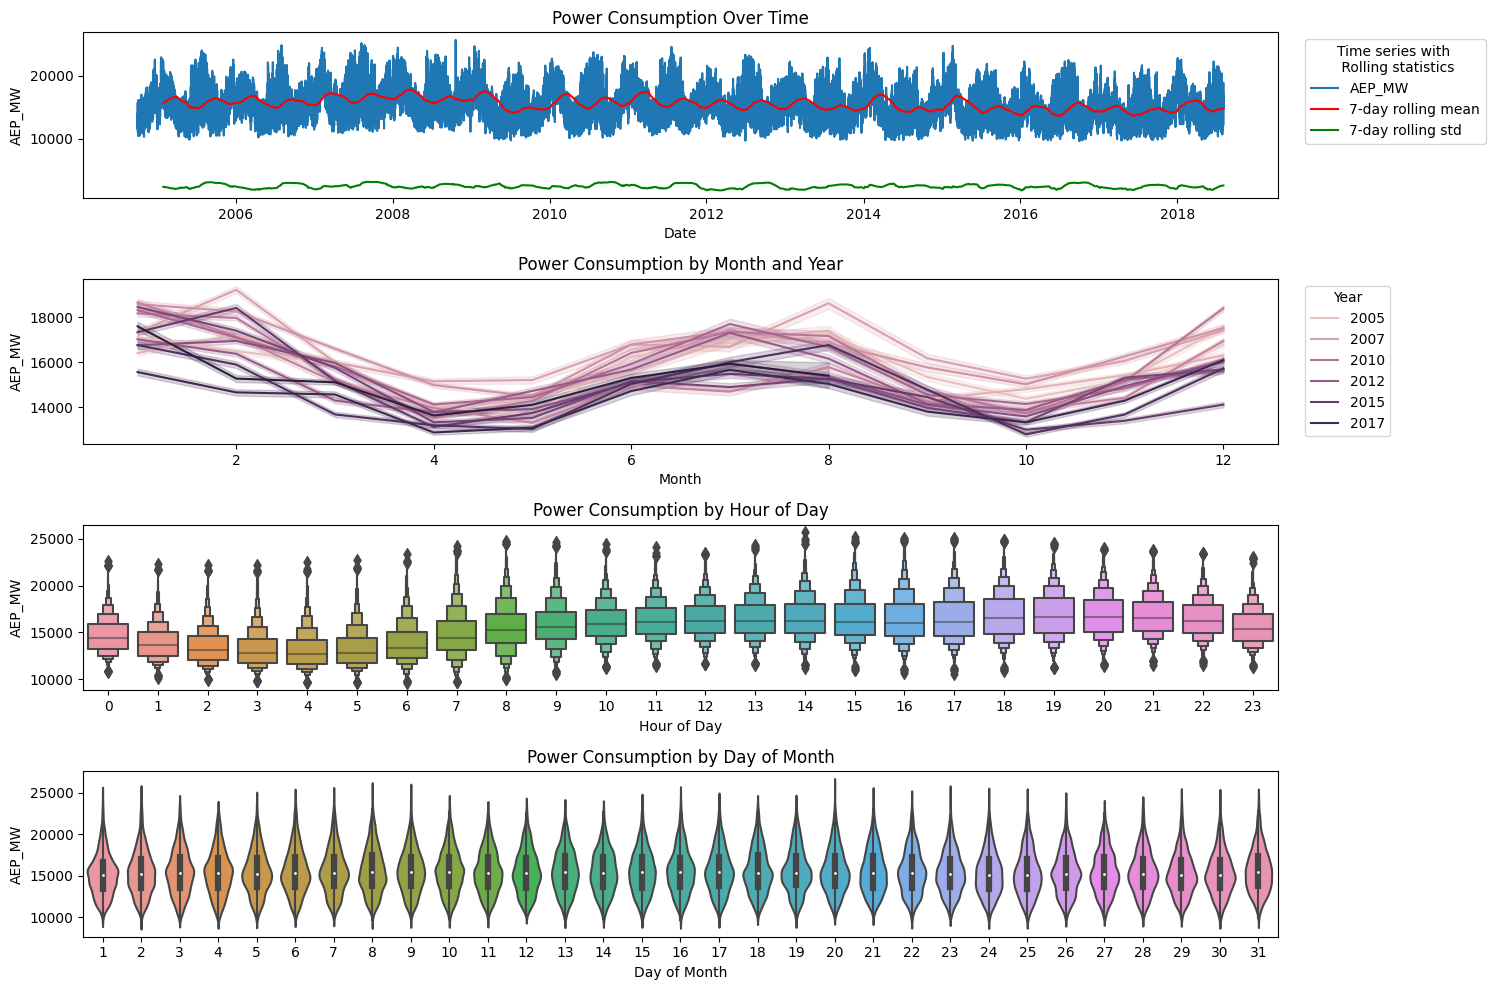

In [44]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10))

# 1. Power consumption over time with rolling statistics
# Create rolling statistics
days = 120 # Number of days for the rolling window
rolling_window = 24*days  
rolling_mean = henergy_df['AEP_MW'].rolling(rolling_window).mean()
rolling_std = henergy_df['AEP_MW'].rolling(rolling_window).std()
dates = henergy_df.index  # full datetime, avoids duplicates
#plot the time series and rolling statistics
sns.lineplot(x=dates, y=henergy_df['AEP_MW'], ax=axs[0], label='AEP_MW')
sns.lineplot(x=dates, y=rolling_mean, ax=axs[0], color='red', label='7-day rolling mean')
sns.lineplot(x=dates, y=rolling_std, ax=axs[0], color='green', label='7-day rolling std')
axs[0].set_title("Power Consumption and Rolling Statistics")
axs[0].legend(title='Time series with \n Rolling statistics', bbox_to_anchor=(1.18, 1), loc='upper right')
axs[0].set_title('Power Consumption Over Time')
axs[0].set_xlabel('Date')

# 2. Power consumption by month and year to see seasonal trends
sns.lineplot(henergy_df, y='AEP_MW', x = 'Month', hue='Year', ax=axs[1])
axs[1].set_title('Power Consumption by Month and Year')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('AEP_MW')
axs[1].legend(title='Year', bbox_to_anchor=(1.1, 1), loc='upper right')

# 3. Power consumption by hour of day to see daily trends
sns.boxenplot(henergy_df, y='AEP_MW', x = 'Hour', ax=axs[2])
axs[2].set_title('Power Consumption by Hour of Day')
axs[2].set_xlabel('Hour of Day')

# 4. Power consumption by day of month to see monthly trends
sns.violinplot(henergy_df, y='AEP_MW', x = 'Day', ax=axs[3])
axs[3].set_title('Power Consumption by Day of Month')
axs[3].set_xlabel('Day of Month')

plt.tight_layout()
plt.show()


Based on the visual inspection I can see a slight trend in the data, however is a small decrease in the energy consumption over the years. Nevertheless to check if the trend has some statistical significance I will use a statistical test. The Augmented Dickey-Fuller test is a common test to check for trend in time series data. 

years wont be used as feature of the model, nor the day of the month as they not play a significant role in the energy consumption but by checking the trend of the model this could change , however the month and the hour of the day will be used as features of the model. I can see that the data has seasonality. Some observations are: 

- Energy consumption is higher in both winter and summer months, with a peak in January and Agust.
    - This is expected as in winter the energy consumption is higher due to heating and in summer the energy consumption is higher due to cooling.
- Energy consumption is lower in spring and autumn months, with a low in April and October.
- The day of the month does not have a significant impact on the energy consumption, however the hour of the day does have a significant impact on the energy consumption.
    - Energy consumption is higher during the evening and lower during the night.
    - This is expected as during the day people are more active and use more energy, while at night people are sleeping and using less energy.

### Checking the trend of the time series data for stationarity
Even if in the past plots the data does not have a significant trend, the question arises if it can be considered stationary or if it would be better to preprocess the data to make it stationary.
To check this I will use the Augmented Dickey-Fuller test. 

$H_0$ - The null hypothesis of this test is that the time series data has a unit root, which means that it is not stationary.
$H_1$ - The alternative hypothesis is that the time series data does not have a unit root, which means that it is stationary.

If the p-value of the test is less than 0.05, we can reject the null hypothesis and conclude that the time series data is stationary.

other ways to check using the ADF test is to comapre the test statistic with the critical values of the test. If the test statistic is less than the critical value, we can reject the null hypothesis and conclude that the time series data is stationary.

ADF Statistic: -18.306039800385413
p-value: 2.2812839721932943e-30
Critical Value (1%): -3.4304039570988323
Critical Value (5%): -2.861563848238303
Critical Value (10%): -2.566782693574735
Reject the null hypothesis: The time series is stationary at 1% significance level.


Text(0.5, 0, 'Power Consumption (MW)')

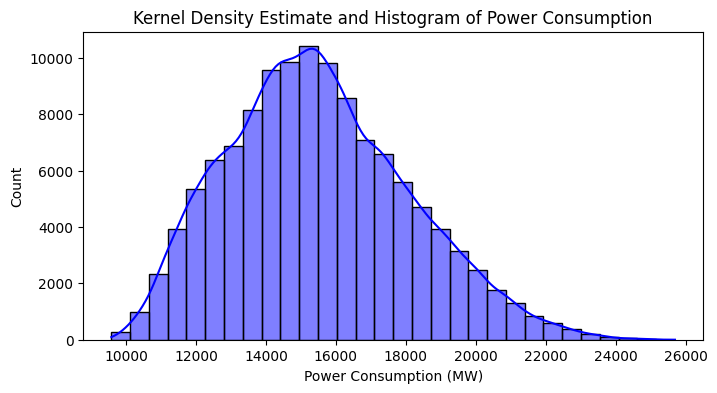

In [45]:
# I will use the Augmented Dickey-Fuller test to check if the time series is stationary.
analyse_ADF_sstats(adfuller(henergy_df['AEP_MW'].values))

fig, ax = plt.subplots(figsize=(8, 4))
# 5. Kernel Density Estimate and Histogram of Power Consumption
sns.histplot(henergy_df['AEP_MW'], bins=30, kde=True, ax=ax, color='blue', label='Histogram')
ax.set_title('Kernel Density Estimate and Histogram of Power Consumption')
ax.set_xlabel('Power Consumption (MW)')



The results of the ADF provide enough evidence to reject the null hypothesis and conclude that the time series data is stationary. This means that the data does not have a significant trend and can be used as is for modeling.
I also made a kde plot with a hsitogram to check the distribution of the data. If it was stationary the olot should have a nnormal distribution, in this case the distribution has a slight skewness to the left, however given the ADF test results, I can conclude that the data is stationary and does not need to be transformed to make it stationary.

c:\Users\hecma\anaconda3\envs\PVproject\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


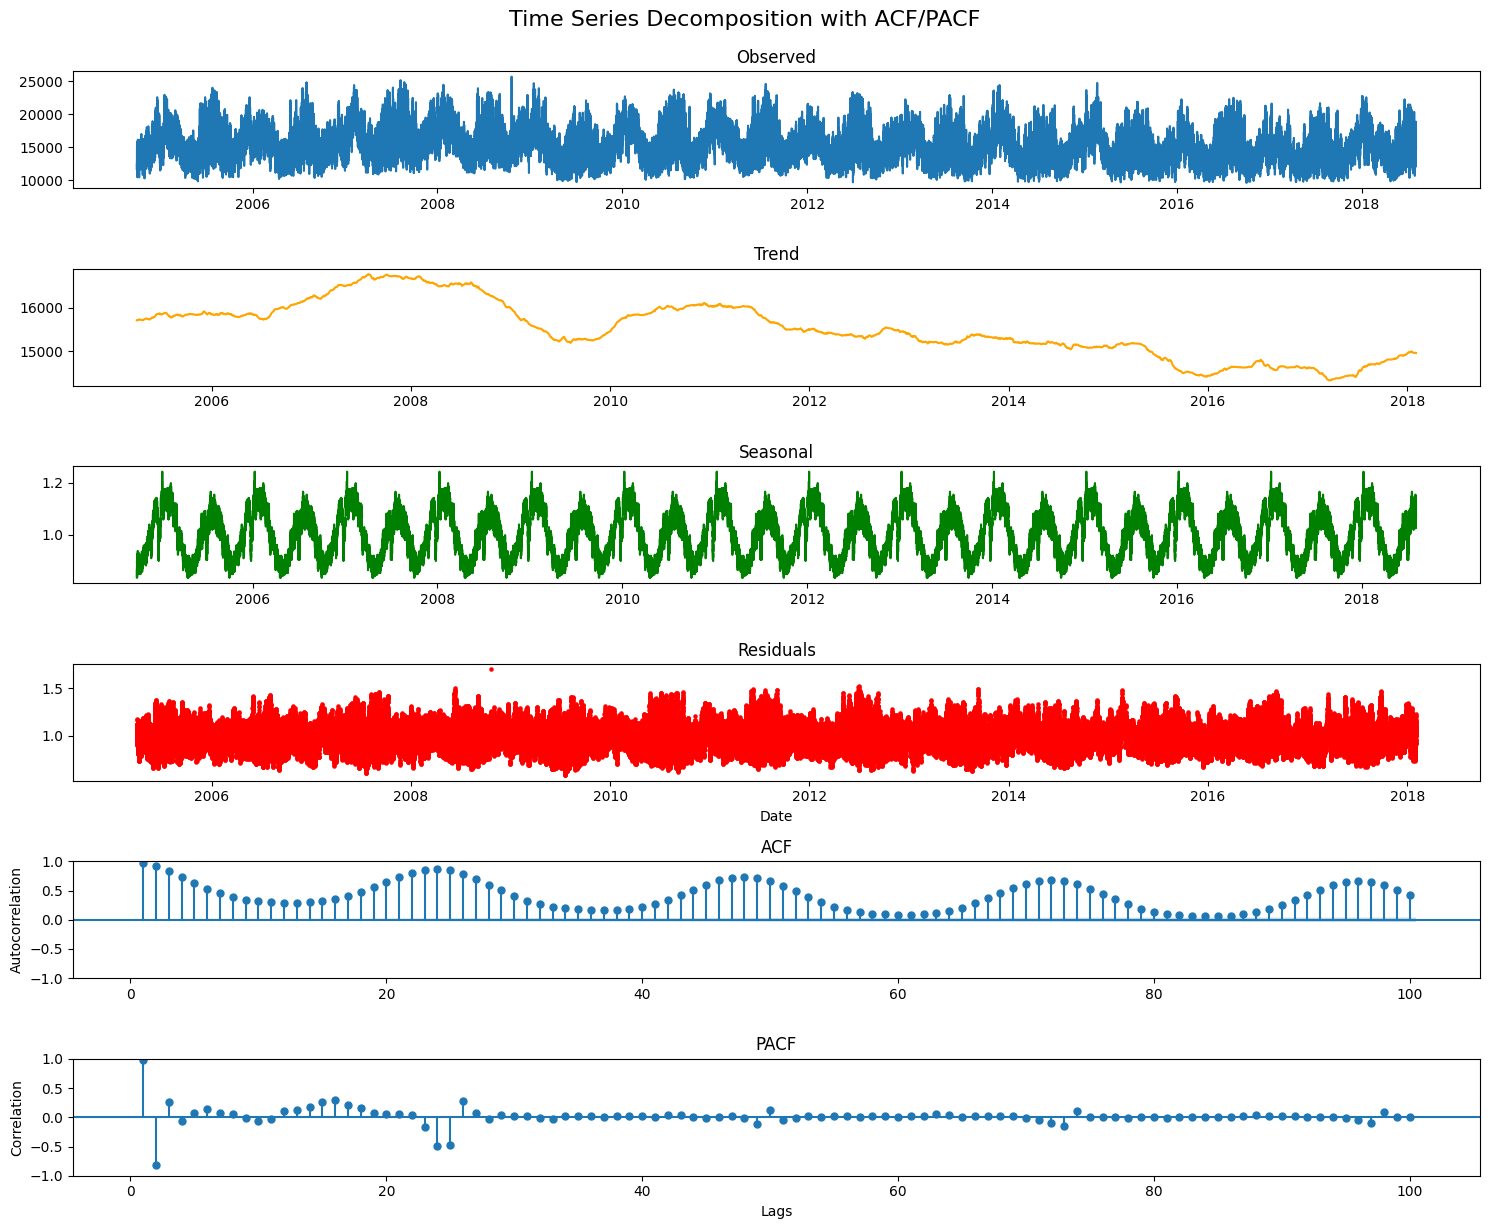

In [46]:

season_dec = seasonal_decompose(henergy_df_nprocessed['AEP_MW'], model='multiplicative', period=24*365)

# Plotting decomposition + ACF/PACF
fig, axs = plt.subplots(6, 1, figsize=(15, 12))

# 1. Plot of the original observed data
axs[0].plot(season_dec.observed)
axs[0].set_title('Observed')
# 2. Plot of the trend component
axs[1].plot(season_dec.trend, color='orange')
axs[1].set_title('Trend')

axs[2].plot(season_dec.seasonal, color='green')
axs[2].set_title('Seasonal')

axs[3].scatter(season_dec.resid.index, season_dec.resid, color='red', s=5)
axs[3].set_title('Residuals')
axs[3].set_xlabel('Date')

n_lags = 100
sm.graphics.tsa.plot_acf(henergy_df_nprocessed['AEP_MW'], lags=n_lags, ax=axs[4], title="ACF", zero=False)
sm.graphics.tsa.plot_pacf(henergy_df_nprocessed['AEP_MW'], lags=n_lags , ax=axs[5], title="PACF", zero=False)
axs[5].set_xlabel('Lags')
axs[4].set_ylabel('Autocorrelation')
axs[5].set_ylabel('Correlation')

fig.tight_layout()
fig.suptitle('Time Series Decomposition with ACF/PACF', fontsize=16, y=1.02)

plt.show()

**Insiughts on the seasonal decomposition of the time series data**

The seasonal decomposition of the time series data shows that the data has a clear seasonal pattern. The seasonal component shows that the energy consumption is higher in winter and summer months, with a peak in January and August. The trend component shows a slight decrease in energy consumption over the years, which is consistent with the visual inspection of the data. The residual component shows that there are some fluctuations in the data that are not explained by the trend and seasonal components, which is expected as the considered window is yearly, and this variations are present due to the hour of the day and the month of the year.

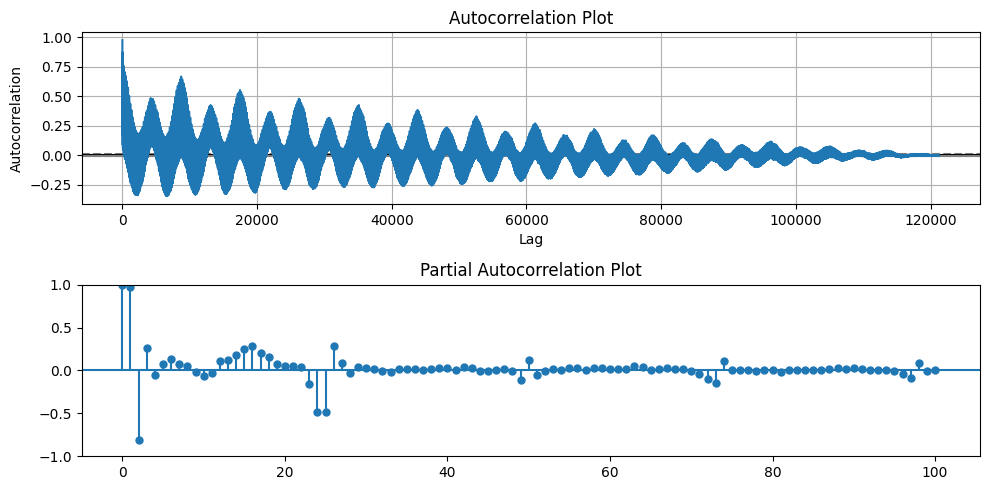

In [47]:
# Plot the ACF and PACF
fig, axs = plt.subplots(2, 1, figsize=(10,5))
autocorrelation_plot(henergy_df_nprocessed['AEP_MW'],ax=axs[0]) # Plot the autocorrelation
plot_pacf(henergy_df_nprocessed['AEP_MW'], lags=100, ax=axs[1], method='ywm') # Plot first 20 lags
axs[0].set_title('Autocorrelation Plot')
axs[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.show()

## Feature engineering 

In [48]:
from statsmodels.tsa.stattools import pacf

pacf_values = pacf(henergy_df['AEP_MW'], nlags=100)  # Calculate PACF values up to 20 lags
print("Partial Autocorrelation Function (PACF) values:")
lag_df = pd.DataFrame({'Lag': range(len(pacf_values)), 'PACF': pacf_values})
lag_df.sort_values(by='PACF', inplace=True)

postive_lags = lag_df[0:5]
negative_lags = lag_df[-5:]

print("Positive Lags:")
print(postive_lags)
print("\nNegative Lags:")
print(negative_lags)
# I will use only the 10 most representative lags for the model


Partial Autocorrelation Function (PACF) values:
Positive Lags:
    Lag      PACF
2     2 -0.815108
24   24 -0.487746
25   25 -0.480714
23   23 -0.162363
73   73 -0.143658

Negative Lags:
    Lag      PACF
3     3  0.261749
26   26  0.284194
16   16  0.287115
1     1  0.976222
0     0  1.000000


In [49]:
lags_use = postive_lags['Lag'].tolist() + negative_lags['Lag'].tolist()
lags_use = [int(lag) for lag in lags_use]  # Convert to integers
lags_use = sorted(lags_use)[1:]  # Sort the lags
print("Lags to use in the model:", lags_use)

Lags to use in the model: [1, 2, 3, 16, 23, 24, 25, 26, 73]


In [50]:

for lag in lags_use:
    henergy_df[f'Lag{lag}'] = henergy_df['AEP_MW'].shift(lag)

henergy_df.head()

,Datetime,AEP_MW,Year,Month,Day,Hour,Lag1,Lag2,Lag3,Lag16,Lag23,Lag24,Lag25,Lag26,Lag73
Datetime,,,,,,,,,,,,,,,
2004-10-01 01:00:00,2004-10-01 01:00:00,12379.0,2004,10,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-01 02:00:00,2004-10-01 02:00:00,11935.0,2004,10,1,2,12379.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-01 03:00:00,2004-10-01 03:00:00,11692.0,2004,10,1,3,11935.0,12379.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-01 04:00:00,2004-10-01 04:00:00,11597.0,2004,10,1,4,11692.0,11935.0,12379.0,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-01 05:00:00,2004-10-01 05:00:00,11681.0,2004,10,1,5,11597.0,11692.0,11935.0,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:

henergy_df.drop(columns=['Datetime','Year', 'Day'], inplace=True)  # Drop the original column to avoid redundancy
henergy_df.dropna(inplace=True)  # Drop rows with NaN values after shifting
henergy_df['Month'] = henergy_df['Month'].astype('category')  # Convert Month to categorical type
henergy_df['Hour'] = henergy_df['Hour'].astype('category')  # Convert Hour to categorical type
henergy_df.head()

,AEP_MW,Month,Hour,Lag1,Lag2,Lag3,Lag16,Lag23,Lag24,Lag25,Lag26,Lag73
Datetime,,,,,,,,,,,,
2004-10-04 02:00:00,11408.0,10,2,11817.0,12351.0,13132.0,12493.0,10600.0,10807.0,11443.0,12172.0,12379.0
2004-10-04 03:00:00,11261.0,10,3,11408.0,11817.0,12351.0,12722.0,10438.0,10600.0,10807.0,11443.0,11935.0
2004-10-04 04:00:00,11247.0,10,4,11261.0,11408.0,11817.0,12908.0,10430.0,10438.0,10600.0,10807.0,11692.0
2004-10-04 05:00:00,11414.0,10,5,11247.0,11261.0,11408.0,12997.0,10509.0,10430.0,10438.0,10600.0,11597.0
2004-10-04 06:00:00,12283.0,10,6,11414.0,11247.0,11261.0,12924.0,10795.0,10509.0,10430.0,10438.0,11681.0


### Cross validation
I will spit the time series data. this is done differntly to a normal set where the data can be split normally. 
Time split splits the data into training and test sets based on time. The training set is the first part of the data and the test set is the last part of the data. This is done to ensure that the model is trained on past data and tested on future data.`

For this I will do a similiar split to [TimeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data) from sklearn.

In [52]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
X = henergy_df.drop(columns=['AEP_MW'])
y = henergy_df['AEP_MW']
X_train, X_test, y_train, y_test = [], [], [], []
for train_index, test_index in tscv.split(henergy_df):
    X_train.append(X.iloc[train_index])
    X_test.append(X.iloc[test_index])
    y_train.append(y.iloc[train_index])
    y_test.append(y.iloc[test_index])  
     
print(f"Number of splits: {n_splits}")
print(f"Number of training sets: {len(X_train)}")
    
    

Number of splits: 5
Number of training sets: 5


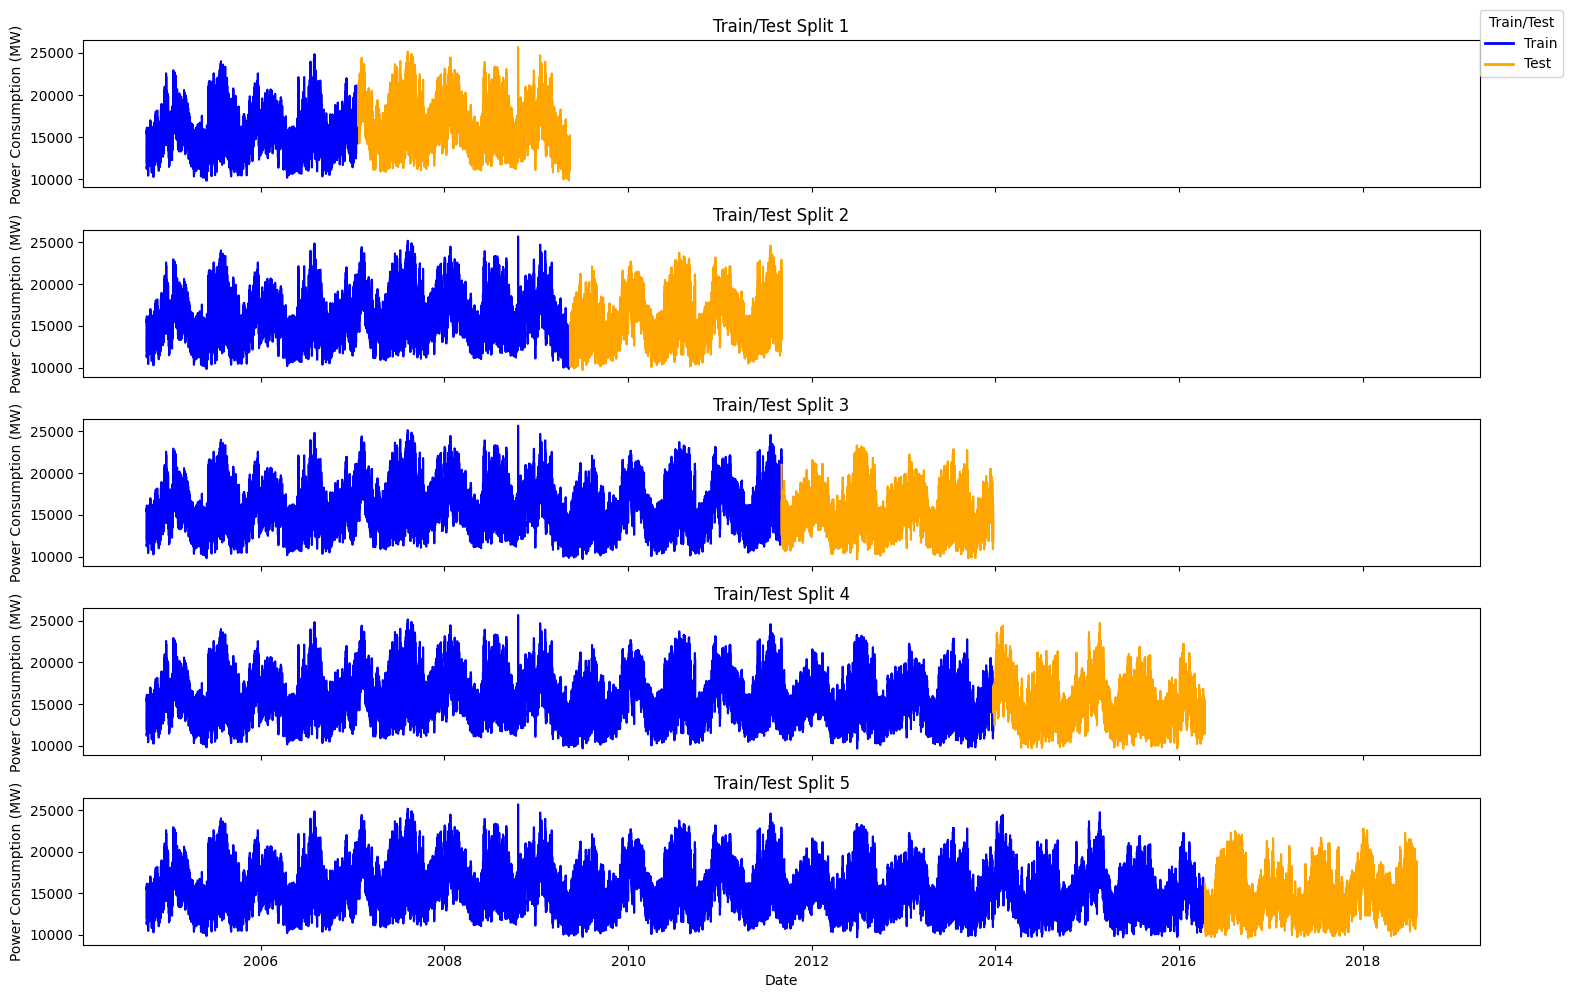

In [53]:
#plot the training and test sets
fig, axs = plt.subplots(n_splits, 1, figsize=(15, 10), sharex=True)
for i in range(n_splits):
    axs[i].plot(X_train[i].index, y_train[i], label='Train', color='blue')
    axs[i].plot(X_test[i].index, y_test[i], label='Test', color='orange')
    axs[i].set_title(f'Train/Test Split {i+1}')
    axs[i].set_ylabel('Power Consumption (MW)')
    
fig.legend(loc='upper right', bbox_to_anchor=(1.05, 1), title='Train/Test', handles=[
    plt.Line2D([0], [0], color='blue', lw=2, label='Train'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Test')])
plt.xlabel('Date')

plt.tight_layout()
plt.show()

# Train the model and fine tune the hyperparameters

To make the tuning of the hyperparameters I will use the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from sklearn. This will allow me to search for the best hyperparameters for the model using cross validation.
I will use the histogram xgboost model for this task. The histogram xgboost model is a fast and efficient implementation of the xgboost algorithm that is optimized for large datasets. It is also more memory efficient than the normal xgboost model, which makes it suitable for this task, moreover if there is a gpu available, it is possible to take advantage of it to speed up the training process.


In [ ]:

# Define XGBRegressor
# In this case I will use a GPU-accelerated version of XGBoost for faster training, as I have an available GPU. 
xgb_model = xgb.XGBRegressor(
    tree_method="hist", 
    device="cuda",
    random_state=42, 
    enable_categorical=True) 

# Define hyperparameter grid
param_grid = {
    'n_estimators': [200, 250, 300],  # Number of trees
    'max_depth': [ 5, 7, 9],  # Maximum depth of a tree
    'learning_rate': [0.1, 0.2, 0.05],  # Step size shrinkage
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    }

# GridSearchCV (e.g., with TimeSeriesSplit stored in `tscv`)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)



def Train_and_test(X_train, y_train, X_test, y_test, k_fold, grid_search):
    """This function trains the model and tests it on the test set."""
    # Fit
    grid_search.fit(X_train[k_fold], y_train[k_fold])  # Use DataFrame directly

    # Best model & prediction
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test[k_fold])

    # Evaluation
    mse = mean_squared_error(y_test[k_fold], y_pred)
    r2 = r2_score(y_test[k_fold], y_pred)
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(y_test[k_fold].index, y_test[k_fold], label='True data', color='blue')
    plt.plot(y_test[k_fold].index, y_pred, label='Predicted data', color='red', alpha=0.7)
    plt.title('XGBoost Predictions vs Actual Values')
    plt.legend(title='Data', bbox_to_anchor=(1.1, 1), loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Power Consumption (MW)')
    plt.xticks(rotation=45)
    plt.show()
    
    return best_model, y_pred, grid_search.best_params_
    


[19:27:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Root Mean Squared Error: 218.84295614299282
R-squared: 0.9931633903785221


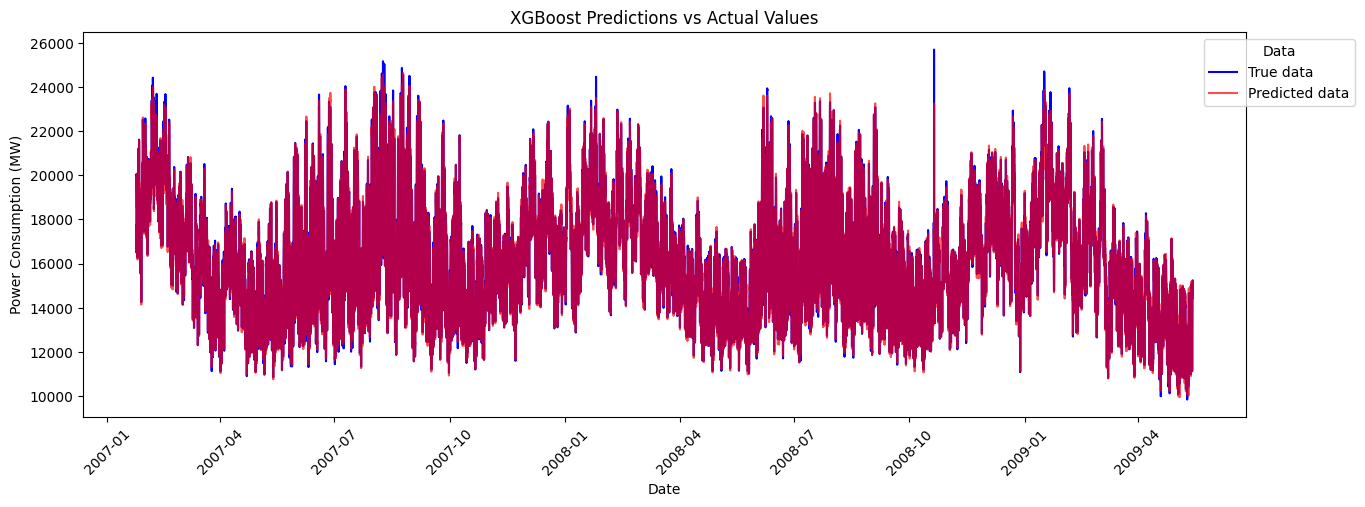

(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...),
 array([17680.059, 16945.629, 16738.895, ..., 15103.748, 14830.57 ,
        14485.786], dtype=float32),
 {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300})

In [24]:
# Train and test the model
Train_and_test(X_train, y_train, X_test, y_test, 0 , grid_search)

[19:28:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Root Mean Squared Error: 158.33243211712298
R-squared: 0.9964887245346811


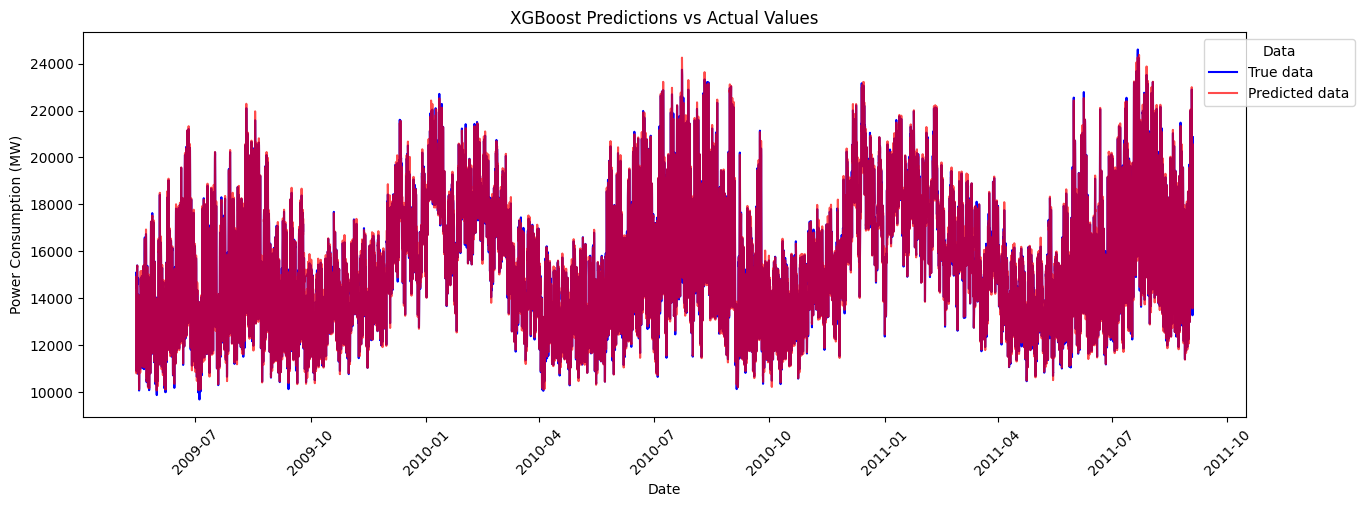

[19:30:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Root Mean Squared Error: 155.2231544082553
R-squared: 0.9955828654305043


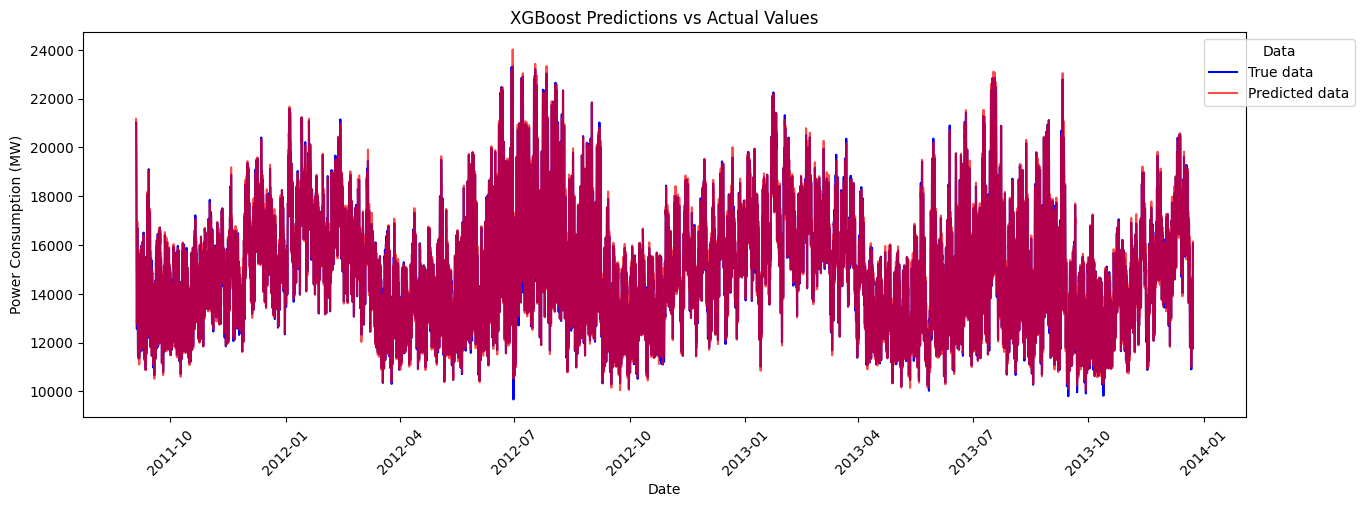

[19:32:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Root Mean Squared Error: 156.21472071054131
R-squared: 0.9962845612388697


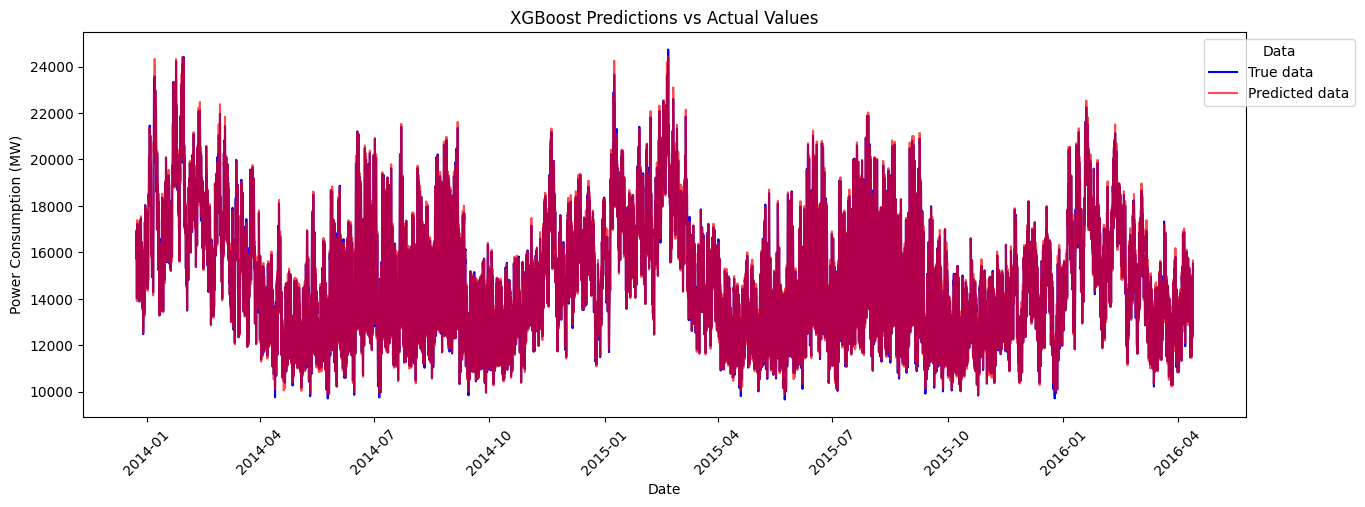

[19:34:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Root Mean Squared Error: 144.84495662543023
R-squared: 0.9966192345602718


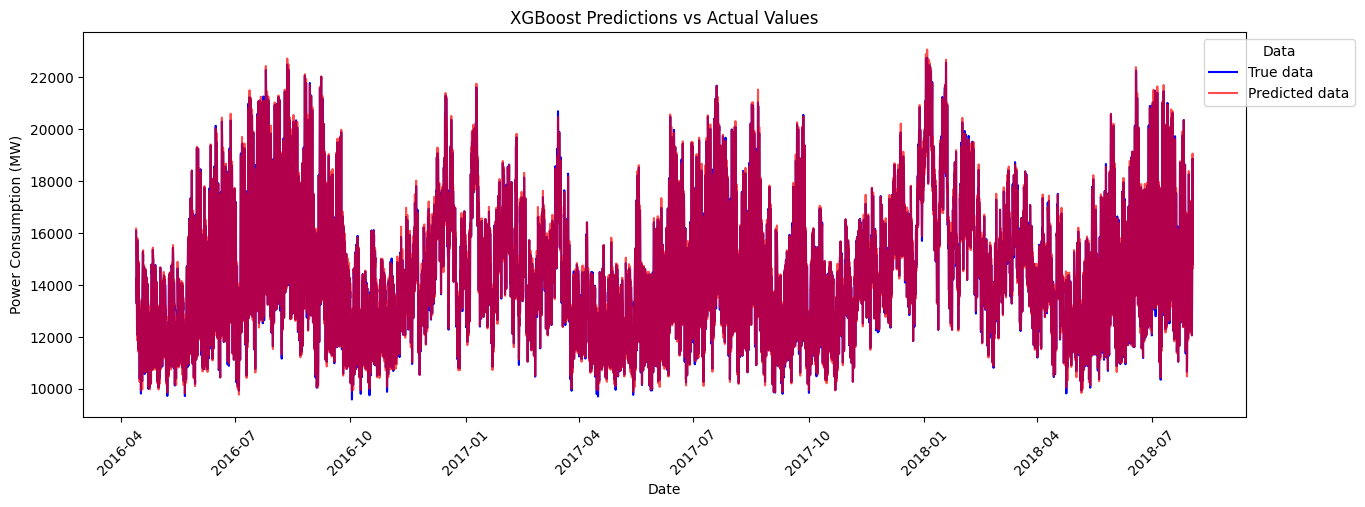

(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...),
 array([16165.748, 16016.043, 15334.889, ..., 16929.895, 15831.324,
        14641.921], dtype=float32),
 {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300})

In [25]:
Train_and_test(X_train, y_train, X_test, y_test, 1 , grid_search)
Train_and_test(X_train, y_train, X_test, y_test, 2 , grid_search)
Train_and_test(X_train, y_train, X_test, y_test, 3 , grid_search)
Train_and_test(X_train, y_train, X_test, y_test, 4 , grid_search)
# Train and test the model with the best hyperparameters

After iteratintg through the hyperparameters, I found that the best hyperparameters for the model, by cheching with the cross validation to see if the model was not overfitting the data, the results ware consitent and the model was able to generalize well to the test set. The best hyperparameters found were:

```python
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
```	

[19:36:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Root Mean Squared Error: 144.84495662543023
R-squared: 0.9966192345602718


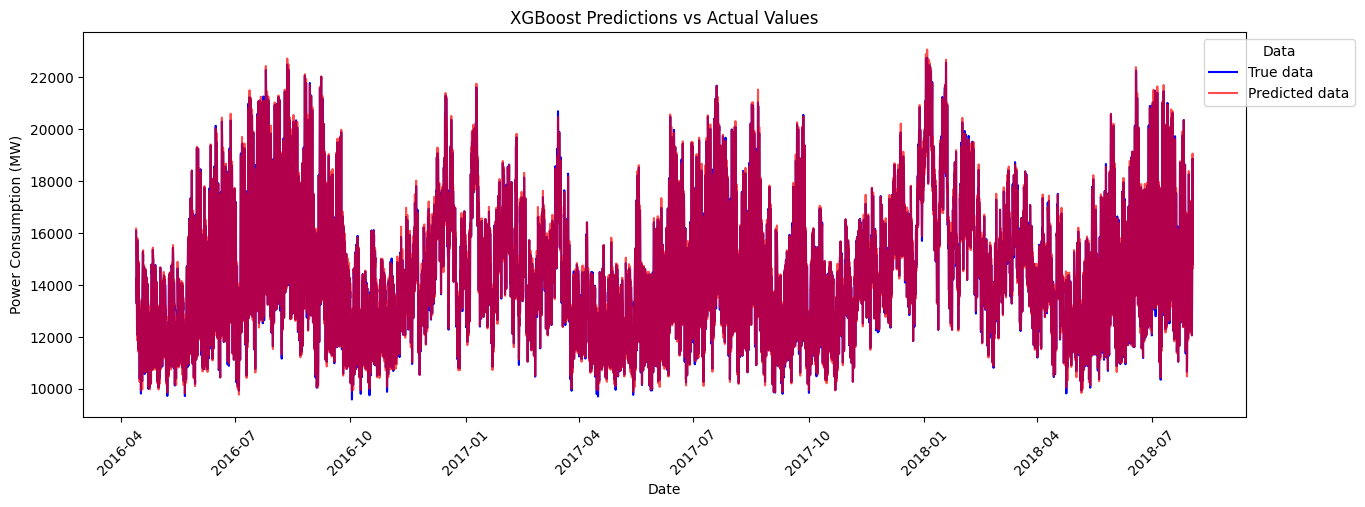

In [26]:
best_model, y_pred, best_params = Train_and_test(X_train, y_train, X_test, y_test, 4 , grid_search) 


[19:36:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Root Mean Squared Error: 144.84495662543023
R-squared: 0.9966192345602718


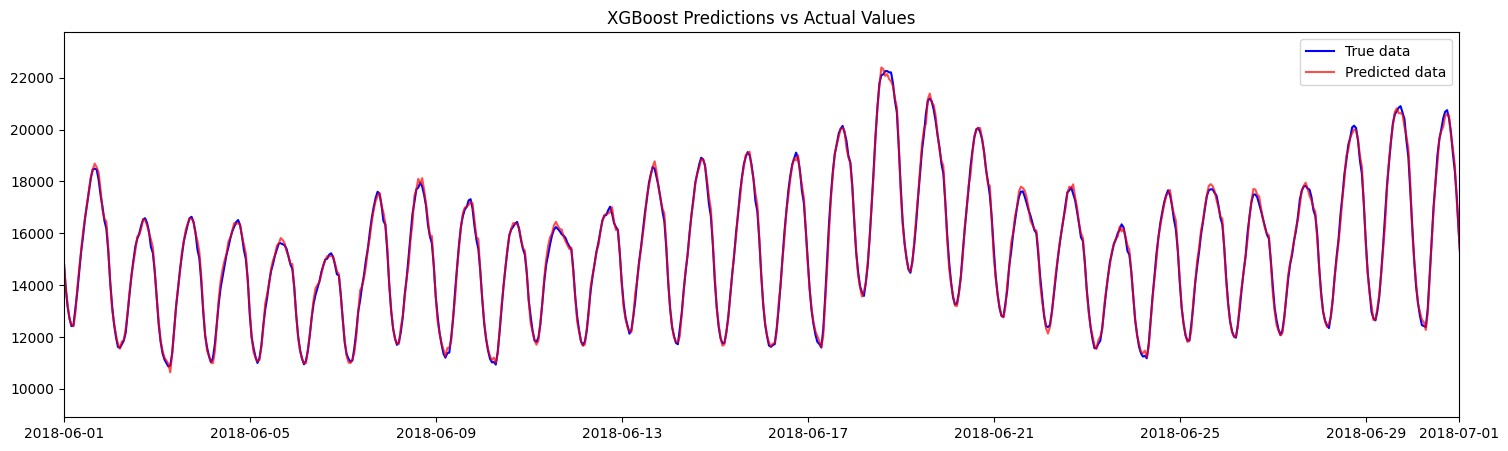

In [27]:
xgb_model = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    tree_method="hist",
    enable_categorical=True,
    device="cuda")
# Fit the model on the entire training set
xgb_model.fit(X_train[4], y_train[4])
# Make predictions on the test set
y_pred = xgb_model.predict(X_test[4])
# Evaluate the model
mse = mean_squared_error(y_test[4], y_pred)
r2 = r2_score(y_test[4], y_pred)
print("Best Hyperparameters:", best_params)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
# Plot the predictions vs actual values
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(y_test[4].index, y_test[4], label='True data', color='blue')
ax.plot(y_test[4].index, y_pred, label='Predicted data', color='red', alpha=0.7)
ax.set_xlim(pd.to_datetime('2018-06-01'), pd.to_datetime('2018-07-01'))
ax.set_title('XGBoost Predictions vs Actual Values')
ax.legend()
plt.show()


Mean of Residuals: -14.772894175608942
Standard Deviation of Residuals: 144.09320238059604


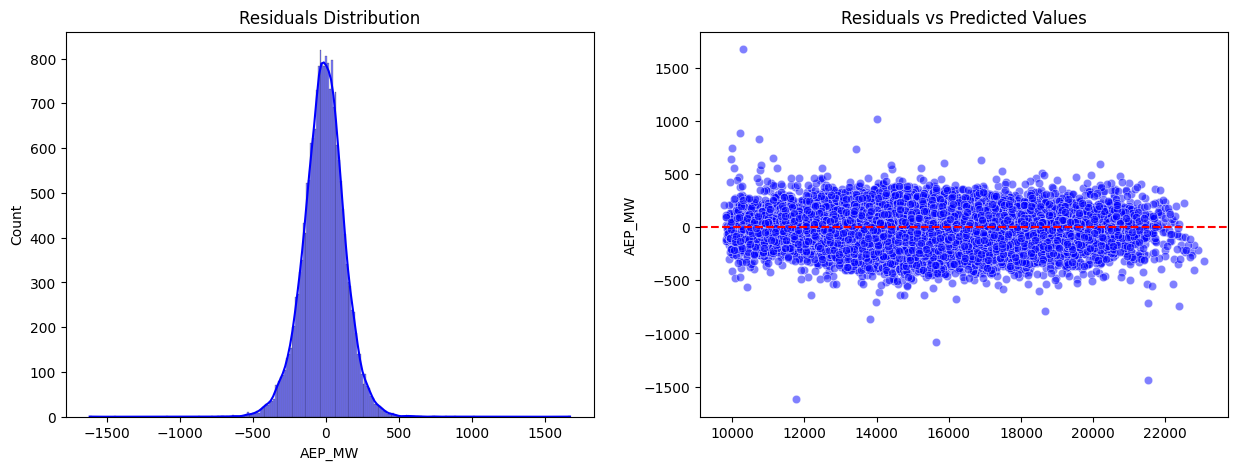

In [ ]:
#Save the model to a file to use it later
xgb_model.save_model("../saved_models/xgb_energy_model.json")
# import the model from the file
xgb_model_loaded = xgb.XGBRegressor()
xgb_model_loaded.load_model("../saved_models/xgb_energy_model.json")

# I am going to check the residuals of the model to see if they are normally distributed.
y_pred = xgb_model_loaded.predict(X_test[4])
residuals = y_test[4] - y_pred

# Plot the residuals
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(residuals, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Residuals Distribution')
sns.scatterplot(x=y_pred, y=residuals, color='blue', alpha=0.5, ax=ax[1])
ax[1].set_title('Residuals vs Predicted Values')
plt.axhline(0, color='red', linestyle='--')

print(f"Mean of Residuals: {residuals.mean()}")
print(f"Standard Deviation of Residuals: {residuals.std()}")

The residuals follow a normal distribution, which indicates that the model successfully captures the underlying structure and seasonality of the data without overfitting.
Normally distributed residuals suggest that the remaining errors are random, rather than systematic — meaning the model isn't missing any obvious patterns.
The standard deviation of the residuals (~144 MW) represents the typical deviation between the predicted and actual values. This residual error likely stems from unpredictable external factors, such as:

- Sudden weather changes
- Holidays or special events
- Changes in industrial activity
- Adoption of more efficient technologies or appliances
- These kinds of fluctuations are difficult for any model to predict precisely and are expected to contribute to noise in the data.